In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob2 import glob 
import nibabel as nib

from tqdm import tqdm 
import mpu

##  Volumes for GBM

In [9]:
import os
import sys
import argparse
import numpy as np
import torch
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm
import torch.nn as nn
import ants
import json

In [65]:
def get_path_to_predict(folder,seed):
    all_sub_path = []
    folds = ['fold_0', 'fold_1', 'fold_2']
    for fold in folds:
        for sub in seed[fold]:
            sub_path = glob('{}/*_fold={}_tta/{}.npy.npz'.format(folder, fold[-1], sub))
            assert(len(sub_path) == 1)
            all_sub_path.append(sub_path[0])
    return all_sub_path

In [66]:
path_pred = '/mnt/experiments/'
path = '/mnt/private_data/'

In [67]:
gt_exp_name = ['gbm_1_reg_train','gbm_2a_interp', 'gbm_3a_atlas', 'gbm_4a_resamp', 'gbm_4b_n4', 'gbm_4d_susan', 'gbm_5_ss_shared']
pred_exp_name = ['/mnt/experiments/gbm_infer/gbm_1_reg_train','/mnt/newdata/gbm_infer/gbm_2a_interp_300', '/mnt/newdata/gbm_infer/gbm_3a_atlas_300', '/mnt/experiments/gbm_infer/gbm_4a_resamp',
           '/mnt/newdata/gbm_infer/gbm_4b_n4_300', '/mnt/newdata/gbm_infer/gbm_4d_susan_300', '/mnt/experiments/gbm_infer/gbm_5_ss_shared_300' , ]    

In [62]:
os.listdir('/mnt/newdata')

['lost+found',
 'data',
 'niir',
 'ssl_anatomy',
 'schw_results',
 'egd_results',
 'test',
 'gbm_infer',
 'bgpd_infer',
 'temp',
 'chest-xray-14',
 'schw',
 'schw_infer',
 'lgg_results',
 'brats_results',
 'lgg_infer',
 'rsna22',
 'ood_tutorial',
 'gbm_1_reg_train',
 'bgpd_results',
 'egd_infer',
 'gbm_results']

In [56]:
os.listdir('/mnt/experiments/gbm_infer')

['gbm_5_ss_shared',
 '6_histogram_fold_2',
 '6_histogram_fold_0',
 'gbm_4a_resamp_unetr_param',
 'gbm_5_ss_shared_unetr_param',
 'gbm_4b_n4_unetr_param',
 'gbm_4d_susan_unetr_param',
 'gbm_4a_resamp_wo_z',
 'gbm_4a_resamp',
 'gbm_1_reg_train',
 'gbm_4b_n4',
 'gbm_2a_interp',
 '6_histogram_fold_1',
 'gbm_4d_susan',
 'gbm_3a_atlas',
 'gbm_4a_resamp_ct1',
 'gbm_4a_resamp_100',
 'gbm_4a_resamp_flair',
 'gbm_4a_resamp_aug',
 'gbm_5_ss_shared_300']

In [50]:
os.listdir('/mnt/private_data/gbm/gbm_4a_resamp/labels')

['TCGA-06-1802_seg.nii.gz',
 'TCGA-02-0011_seg.nii.gz',
 'TCGA-02-0034_seg.nii.gz',
 'TCGA-08-0509_seg.nii.gz',
 'TCGA-08-0360_seg.nii.gz',
 'TCGA-19-2624_seg.nii.gz',
 'TCGA-02-0116_seg.nii.gz',
 'TCGA-06-6389_seg.nii.gz',
 'TCGA-14-3477_seg.nii.gz',
 'TCGA-06-0119_seg.nii.gz',
 'TCGA-76-6657_seg.nii.gz',
 'TCGA-06-0190_seg.nii.gz',
 'TCGA-08-0392_seg.nii.gz',
 'TCGA-02-0087_seg.nii.gz',
 'TCGA-02-0068_seg.nii.gz',
 'TCGA-76-6282_seg.nii.gz',
 'TCGA-12-1598_seg.nii.gz',
 'TCGA-02-0102_seg.nii.gz',
 'TCGA-02-0027_seg.nii.gz',
 'TCGA-19-5951_seg.nii.gz',
 'TCGA-06-0122_seg.nii.gz',
 'TCGA-12-1601_seg.nii.gz',
 'TCGA-06-0182_seg.nii.gz',
 'TCGA-14-1825_seg.nii.gz',
 'TCGA-08-0355_seg.nii.gz',
 'TCGA-02-0106_seg.nii.gz',
 'TCGA-02-0059_seg.nii.gz',
 'TCGA-06-5408_seg.nii.gz',
 'TCGA-06-0154_seg.nii.gz',
 'TCGA-08-0385_seg.nii.gz',
 'TCGA-12-0616_seg.nii.gz',
 'TCGA-14-1794_seg.nii.gz',
 'TCGA-76-6662_seg.nii.gz',
 'TCGA-14-1456_seg.nii.gz',
 'TCGA-02-0009_seg.nii.gz',
 'TCGA-02-0046_seg.n

In [68]:
seed = mpu.io.read('/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/metrics/gbm_seed.json')
df_gt_volumes = pd.DataFrame()
all_sub = [s.split('/')[-1][:-11] for s in glob(f'{path}gbm/gbm_4a_resamp/labels/*_seg.nii.gz')]
df_gt_volumes['SubjectId']=all_sub
df_gt_volumes.set_index('SubjectId', inplace=True)

df_pred_volumes = pd.DataFrame()
df_pred_volumes['SubjectId']=all_sub
df_pred_volumes.set_index('SubjectId', inplace=True)

for gt_folder, pred_folder  in zip(gt_exp_name, pred_exp_name):
    pred_subjects = get_path_to_predict(pred_folder,seed)
    for i, pred_sub in enumerate(tqdm(pred_subjects)):
        sub = pred_sub.split('/')[-1][:-8]
        label = nib.load(f'{path}/gbm/{gt_folder}/labels/{sub}_seg.nii.gz').get_fdata().astype(np.uint8)
        predict = np.round(np.load(pred_sub, allow_pickle=True)['arr_0']).transpose((0, 3, 2, 1)).astype(np.uint8)
        vox_size = 1
        y_wt, y_tc, y_et = label > 0, ((label == 1) + (label == 3)) > 0, label == 3
        df_gt_volumes.loc[sub, f'{gt_folder}_volume_WT']=np.sum(y_wt)*(vox_size**3)/1000
        df_pred_volumes.loc[sub, f'{gt_folder}_volume_WT'] =np.sum(predict[0,:]==1)*(vox_size**3)/1000
        
        df_gt_volumes.loc[sub, f'{gt_folder}_volume_TC']=np.sum(y_tc)*(vox_size**3)/1000
        df_pred_volumes.loc[sub, f'{gt_folder}_volume_TC'] =np.sum(predict[1,:]==1)*(vox_size**3)/1000
        
        df_gt_volumes.loc[sub, f'{gt_folder}_volume_ET']=np.sum(y_et)*(vox_size**3)/1000
        df_pred_volumes.loc[sub, f'{gt_folder}_volume_ET'] =np.sum(predict[2,:]==1)*(vox_size**3)/1000
     

100%|██████████| 102/102 [01:50<00:00,  1.09s/it]


In [74]:
df_mae

,WT (Mean),TC (Mean),ET (Mean),WT (STD),TC (STD),ET (STD)
Experiments,,,,,,
gbm_1_reg_train,34.724088,15.758284,9.376373,33.046039,19.930526,10.706706
gbm_2a_interp,15.666108,7.621775,5.791794,16.149577,11.398546,9.550164
gbm_3a_atlas,13.076814,7.436216,5.639176,11.268876,10.050481,9.415561
gbm_4a_resamp,14.359069,6.984549,5.736961,13.003059,9.045553,8.721547
gbm_4b_n4,14.965363,7.049500,6.089647,14.786446,8.746443,6.925818
gbm_4d_susan,12.875049,6.894216,5.407618,12.989846,8.838672,9.011633
gbm_5_ss_shared,9.637843,5.846255,4.496549,8.982842,10.690795,8.505935


In [121]:
np.abs(df_pred_volumes[f'{gt_folder}_volume_WT'].values)

array([130.138,  89.794, 140.503,  29.983,  37.503, 121.63 ,  51.661,
        58.053, 142.885, 156.636, 129.966, 151.151, 140.806,  90.982,
        81.364, 199.746, 110.907,  23.449,  49.748,  55.76 ,  69.317,
        62.247, 127.133, 147.632, 112.085,  79.175, 121.001, 165.381,
        82.621,  93.133,  62.947, 162.044,  76.282, 124.252,  16.527,
       125.862,  29.721,  34.421, 111.997,  94.715, 100.784,  66.993,
        74.43 ,  81.363,  48.063, 121.16 ,  78.869,  41.093,  39.344,
        13.967,  79.503,  84.886,  67.705, 165.329, 131.622,  71.61 ,
        38.371,  31.386,  83.362,  34.908,  43.959,  72.096,  91.775,
       134.237, 177.358,  67.877,  67.507,  69.921,  72.97 ,  13.536,
        98.171, 134.895, 104.193, 102.146,  48.824, 126.636, 163.233,
        65.893,  61.408, 133.763, 128.663, 137.276, 114.398,  76.297,
       127.505,  88.527, 123.538, 114.935,  98.159,  81.623,  61.752,
        41.556,  64.919,  33.757, 195.943,  66.155,  37.284,  34.113,
        84.658,  56.

In [128]:
df_mae = pd.DataFrame()
df_mae['Experiments']=gt_exp_name
df_mae.set_index('Experiments', inplace=True)
for gt_folder in gt_exp_name:
    df_mae.loc[gt_folder, 'WT (MAE)'] = np.mean(np.abs(df_gt_volumes[f'{gt_folder}_volume_WT'].values - df_pred_volumes[f'{gt_folder}_volume_WT'].values), axis=0)
    df_mae.loc[gt_folder, 'TC (MAE)'] = np.mean(np.abs(df_gt_volumes[f'{gt_folder}_volume_TC'].values - df_pred_volumes[f'{gt_folder}_volume_TC'].values), axis=0)
    df_mae.loc[gt_folder, 'ET (MAE)'] = np.mean(np.abs(df_gt_volumes[f'{gt_folder}_volume_ET'].values - df_pred_volumes[f'{gt_folder}_volume_ET'].values), axis=0)
    df_mae.loc[gt_folder, 'WT (STD)'] = np.std(np.abs( df_pred_volumes[f'{gt_folder}_volume_WT'].values), axis=0)
    df_mae.loc[gt_folder, 'TC (STD)'] = np.std(np.abs(df_pred_volumes[f'{gt_folder}_volume_TC'].values), axis=0)
    df_mae.loc[gt_folder, 'ET (STD)'] = np.std(np.abs( df_pred_volumes[f'{gt_folder}_volume_ET'].values), axis=0)   
    df_mae.loc[gt_folder, 'WT (STD)'] = np.mean(np.abs( df_pred_volumes[f'{gt_folder}_volume_WT'].values), axis=0)
    df_mae.loc[gt_folder, 'TC (STD)'] = np.mean(np.abs(df_pred_volumes[f'{gt_folder}_volume_TC'].values), axis=0)
    df_mae.loc[gt_folder, 'ET (STD)'] = np.mean(np.abs( df_pred_volumes[f'{gt_folder}_volume_ET'].values), axis=0)  

In [130]:
df_mae

,WT (Mean),TC (Mean),ET (Mean),WT (STD),TC (STD),ET (STD)
Experiments,,,,,,
gbm_1_reg_train,34.724088,15.758284,9.376373,44.839931,16.156882,9.718667
gbm_2a_interp,15.666108,7.621775,5.791794,99.857598,41.884657,23.909833
gbm_3a_atlas,13.076814,7.436216,5.639176,92.456049,38.673412,22.308676
gbm_4a_resamp,14.359069,6.984549,5.736961,95.209363,37.216804,21.401569
gbm_4b_n4,14.965363,7.049500,6.089647,88.941363,36.841598,20.854980
gbm_4d_susan,12.875049,6.894216,5.407618,90.984735,38.310373,22.440833
gbm_5_ss_shared,9.637843,5.846255,4.496549,89.882333,35.378588,21.888902


In [78]:
from researchpy import ttest

def ttest_pair(df_1, df_2, name_1 = 'one', name_2 = 'two', correction = None):
    return ttest(pd.Series(df_1), pd.Series(df_2), 
#                  group1_name = name_1,
#                  group2_name= name_2, 
                 equal_variances=False, paired=True,)[1].iloc[4].values[1]

In [89]:
df_pred_volumes.to_csv('GBM_pred_volumes_prediction_space.csv')

In [92]:
df_gt_volumes['gbm_4d_susan_volume_WT']

SubjectId
TCGA-06-1802    135.499
TCGA-02-0011     93.555
TCGA-02-0034    118.749
TCGA-08-0509     24.907
TCGA-08-0360     16.943
                 ...   
TCGA-06-0644     27.436
TCGA-02-0075    110.072
TCGA-02-0064     49.169
TCGA-76-4932     49.851
TCGA-08-0512    147.786
Name: gbm_4d_susan_volume_WT, Length: 102, dtype: float64

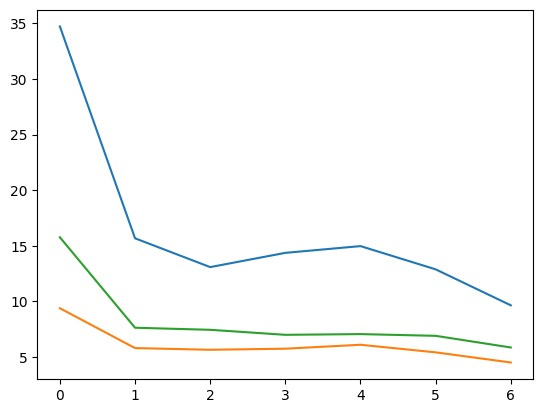

In [117]:
z_axis = np.arange(0,len(df_mae))
plt.plot(z_axis, df_mae['WT (Mean)'])

plt.plot(z_axis, df_mae['ET (Mean)'])
plt.plot(z_axis, df_mae['TC (Mean)'])

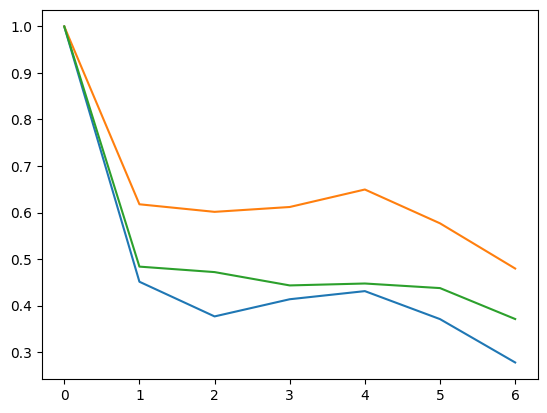

In [116]:
z_axis = np.arange(0,len(df_mae))
plt.plot(z_axis, df_mae['WT (Mean)']/np.max(df_mae['WT (Mean)']))

plt.plot(z_axis, df_mae['ET (Mean)']/np.max(df_mae['ET (Mean)']))
plt.plot(z_axis, df_mae['TC (Mean)']/np.max(df_mae['TC (Mean)']))

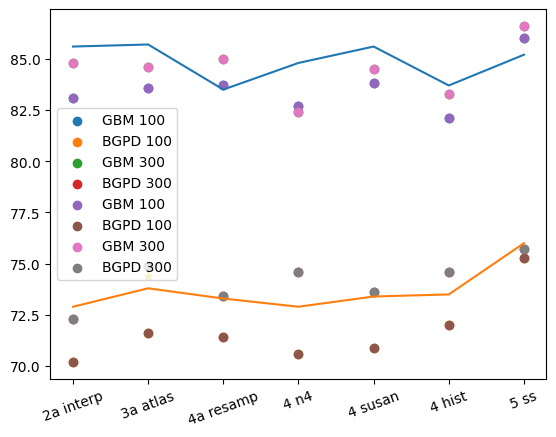

In [126]:
gbm_to_bgpd =  np.array( [0.017,
0.025,
0.021,
-0.002,
0.021,
0.018,
0.016,
-0.008])

gbm_100 =  np.array( [42.3,
83.1,
83.6,
83.7,
82.7,
83.8,
82.1,
86.0])


bgpd_to_gbm =  np.array([0.008,
0.027,
0.022,
0.019,
0.023,
0.025,
0.015,
0.007])

bgpd_100 = np.array(
[34.1,
70.2,
71.6,
71.4,
70.6,
70.9,
72.0,
75.3])



list_tcs = ['1 reg',
'2a interp',
'3a atlas',
'4a resamp',
'4 n4',
'4 susan',
'4 hist',
'5 ss']

bgpd_300 = np.array( [
35.9,
72.3,
74.9,
73.4,
74.6,
73.6,
74.6,
75.7,])

gbm_300 = np.array( [
    
43.6,
84.8,
84.6,
85.0,
82.4,
84.5,
83.3,
86.6,])

# plt.plot(np.arange(1,8),(gbm_to_bgpd*100+gbm_100)[1:] )
# plt.plot(np.arange(1,8),(bgpd_to_gbm*100+bgpd_100 )[1:])
plt.scatter(np.arange(1,8), (gbm_100)[1:], label = 'GBM 100')
plt.scatter(np.arange(1,8), bgpd_100[1:], label = 'BGPD 100')

plt.scatter(np.arange(1,8), (gbm_300)[1:], label = 'GBM 300')
plt.scatter(np.arange(1,8), bgpd_300[1:], label = 'BGPD 300')
# plt.hlines(0,0, 8)
plt.xticks(np.arange(1,8),list_tcs[1:],  rotation=20);
plt.legend();

plt.plot(np.arange(1,8),(gbm_to_bgpd*100+gbm_100)[1:] )
plt.plot(np.arange(1,8),(bgpd_to_gbm*100+bgpd_100 )[1:])
plt.scatter(np.arange(1,8), (gbm_100)[1:], label = 'GBM 100')
plt.scatter(np.arange(1,8), bgpd_100[1:], label = 'BGPD 100')

plt.scatter(np.arange(1,8), (gbm_300)[1:], label = 'GBM 300')
plt.scatter(np.arange(1,8), bgpd_300[1:], label = 'BGPD 300')
plt.scatter(2, 74.4, marker ='*')
# plt.hlines(0,0, 8)
plt.xticks(np.arange(1,8),list_tcs[1:],  rotation=20);
plt.legend();

### Graph

In [103]:
np.mean(df_gt_volumes['gbm_4a_resamp_volume_WT'].values)*0.1

8.899890196078433

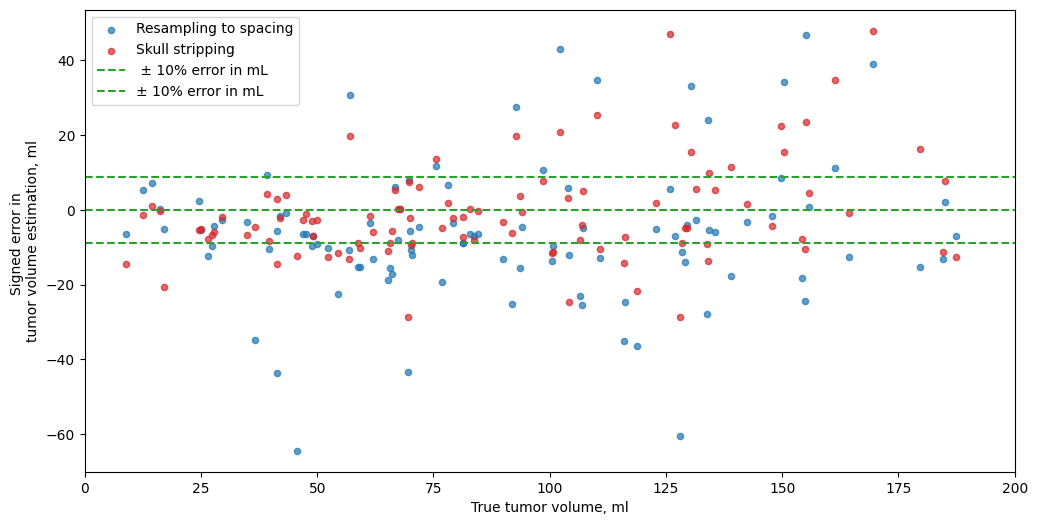

In [109]:
# Bland-Altman-like

# plt.plot([0, 220], [0, 220], ls='--', color='g')

plt.figure(figsize=(12,6))
plt.scatter(df_gt_volumes['gbm_4a_resamp_volume_WT'].values, 
            (df_gt_volumes['gbm_4a_resamp_volume_WT'].values - df_pred_volumes['gbm_4a_resamp_volume_WT'].values), s = 20, alpha=0.7, c='tab:blue', label='Resampling to spacing')

plt.scatter(df_gt_volumes['gbm_5_ss_shared_volume_WT'].values, 
            (df_gt_volumes['gbm_5_ss_shared_volume_WT'].values - df_pred_volumes['gbm_5_ss_shared_volume_WT'].values), s = 20, alpha=0.7, c='tab:red', label='Skull stripping')
plt.hlines(0, 0, 200, linestyles='--', colors='tab:green')
plt.hlines(np.mean(df_gt_volumes['gbm_4a_resamp_volume_WT'].values)*0.1, 0, 200, linestyles='--', colors='tab:green', label =' ± 10% error in mL')
plt.hlines(-np.mean(df_gt_volumes['gbm_4a_resamp_volume_WT'].values)*0.1,0, 200, linestyles='--', colors='tab:green', label ='± 10% error in mL')
plt.xlim(0, 200)
plt.xlabel('True tumor volume, ml')
plt.ylabel('Signed error in \ntumor volume estimation, ml')
plt.legend();

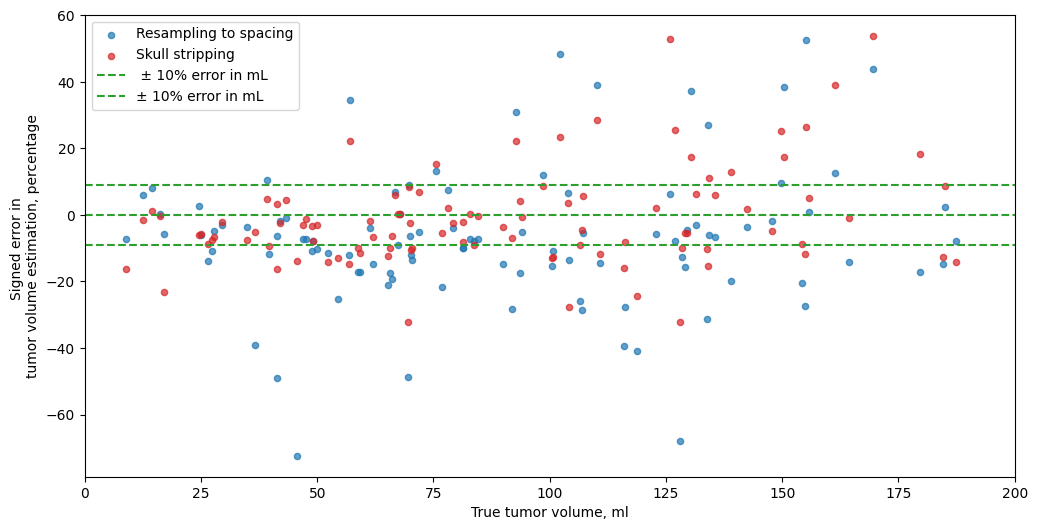

In [131]:
gbm_mean = np.mean(np.abs(df_gt_volumes['gbm_4a_resamp_volume_WT'].values))

plt.figure(figsize=(12,6))

plt.scatter(df_gt_volumes['gbm_4a_resamp_volume_WT'].values, 
            (df_gt_volumes['gbm_4a_resamp_volume_WT'].values - df_pred_volumes['gbm_4a_resamp_volume_WT'].values)/gbm_mean*100, s = 20, alpha=0.7, c='tab:blue', label='Resampling to spacing')

plt.scatter(df_gt_volumes['gbm_5_ss_shared_volume_WT'].values, 
            (df_gt_volumes['gbm_5_ss_shared_volume_WT'].values - df_pred_volumes['gbm_5_ss_shared_volume_WT'].values)/gbm_mean*100, s = 20, alpha=0.7, c='tab:red', label='Skull stripping')
plt.hlines(0, 0, 200, linestyles='--', colors='tab:green')
plt.hlines(gbm_mean*0.1, 0, 200, linestyles='--', colors='tab:green', label =' ± 10% error in mL')
plt.hlines(-gbm_mean*0.1,0, 200, linestyles='--', colors='tab:green', label ='± 10% error in mL')
plt.xlim(0, 200)
plt.xlabel('True tumor volume, ml')
plt.ylabel('Signed error in \ntumor volume estimation, percentage')
plt.legend();

In [96]:
ttest(df_pred_volumes['gbm_4a_resamp_volume_TC'], df_pred_volumes['gbm_4d_susan_volume_TC'], equal_variances=False, paired=True,)

/home/kate/miniconda3/lib/python3.9/site-packages/researchpy/ttest.py:38: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(       sign  obs  sum ranks  expected
 0  positive   36     1674.5    2626.5
 1  negative   66     3578.5    2626.5
 2      zero    0        0.0       0.0
 3       all  102     5253.0    5253.0,
              Wilcoxon signed-rank test      results
 0  Mean for gbm_4a_resamp_volume_TC =     37.216804
 1   Mean for gbm_4d_susan_volume_TC =     38.310373
 2                           W value =   1674.500000
 3                           Z value =     -3.178000
 4                           p value =      0.001500
 5                   Rank-Biserial r =     -0.362500
 6                         Pearson r =     -0.314700)

Check metrics

In [257]:
y_wt, y_tc, y_et = label > 0, ((label == 1) + (label == 3)) > 0, label == 3
lab = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)

In [259]:
z = np.argsort(predict.sum(axis=(1,2)))

In [266]:
label.shape, predict.shape

((200, 200, 150), (3, 200, 200, 150))

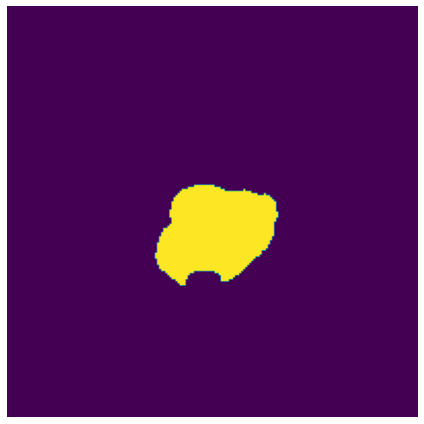

In [264]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
for i in range(1):
        ax.imshow(predict[1,:,:,91]);
        ax.axis('off')  
plt.tight_layout()            
plt.show()

In [265]:
from surface_distance import metrics
print('dice WT')
print(metrics.compute_dice_coefficient((lab[0,:,:,:]==1), (predict[0,:,:,:]==1)))
print('Dice_2')
print(metrics.compute_dice_coefficient((lab[1,:,:,:]==1), (predict[1,:,:,:]==1)))
print('Dice_3')
print(metrics.compute_dice_coefficient((lab[2,:,:,:]==1), (predict[2,:,:,:]==1)))

dice WT
0.8247984557738163
Dice_2
0.7950042050822546
Dice_3
0.7382802035896062


In [247]:
out_json = '/results/metrics/gbm/'
dataset = 'gbm'
task = 'gbm_4a_resamp_aug'
fold = 'fold_2'
_columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 'Precision_2', 'Precision_3']
metrics_all = pd.DataFrame(columns = _columns)
for i,sub in tqdm((enumerate(os.listdir(out_json)))):
    for sub_t in os.listdir(os.path.join(out_json, sub)):
        if f'{task}_epoch' in sub_t:
            if fold in sub_t:
                metrics = json.load(open(os.path.join(out_json, sub, sub_t)))
                metrics = metrics[dataset][task][fold.replace('_', '=')]
                for each in _columns:
                    metrics_all.at[i,'Ids'] = sub
                    if each != 'Ids':
                        metrics_all.at[i,each] = metrics[each]

102it [00:00, 571.65it/s]


In [250]:
metrics_all[metrics_all.Ids=='TCGA-06-5417']

,Ids,Dice_1,Dice_2,Dice_3,Hausdorff95_1,Hausdorff95_2,Hausdorff95_3,Sensitivity_1,Sensitivity_2,Sensitivity_3,Specificity_1,Specificity_2,Specificity_3,Surface_dice_1,Surface_dice_2,Surface_dice_3,Precision_1,Precision_2,Precision_3
101,TCGA-06-5417,0.923928,0.879252,0.691062,44.710707,5.421759,6.406517,0.911336,0.835128,0.646162,0.998946,0.999405,0.999415,0.711407,0.578882,0.815151,0.936873,0.9283,0.742669


for Hist

In [282]:
def get_path_to_predict_hist(folder,seed):
    all_sub_path = []
    folds = ['fold_0', 'fold_1', 'fold_2']
    for fold in folds:
        for sub in seed[fold]:
            sub_path = glob('{}/gbm_6_hist_fold_{}/labels/{}_seg.nii.gz'.format(folder, fold[-1], sub))
            assert(len(sub_path) == 1)
            all_sub_path.append(sub_path[0])
    return all_sub_path

In [283]:
gt_exp_name = ['gbm_6_hist']
pred_exp_name = ['/data/newdata/gbm_infer/gbm_6_histogram_300']

In [284]:
seed = mpu.io.read('/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/metrics/gbm_seed.json')
df_gt_volumes_hist = pd.DataFrame()
all_sub = [s.split('/')[-1][:-11] for s in glob(f'/data/private_data/gbm/gbm_4a_resamp/labels/*_seg.nii.gz')]
df_gt_volumes_hist['SubjectId']=all_sub
df_gt_volumes_hist.set_index('SubjectId', inplace=True)

df_pred_volumes_hist = pd.DataFrame()
df_pred_volumes_hist['SubjectId']=all_sub
df_pred_volumes_hist.set_index('SubjectId', inplace=True)

for gt_folder, pred_folder  in zip(gt_exp_name, pred_exp_name):
    pred_subjects = get_path_to_predict(pred_folder,seed)
    label_subjects = get_path_to_predict_hist(f'/data/private_data/gbm/{gt_folder}',seed)
    for i, pred_sub in enumerate(tqdm(pred_subjects)):
        sub = pred_sub.split('/')[-1][:-8]
        label = nib.load(label_subjects[i]).get_fdata().astype(np.uint8)
        predict = np.round(np.load(pred_sub, allow_pickle=True)['arr_0']).transpose((0, 3, 2, 1)).astype(np.uint8)
        vox_size = 1
        y_wt, y_tc, y_et = label > 0, ((label == 1) + (label == 3)) > 0, label == 3
        df_gt_volumes_hist.loc[sub, f'{gt_folder}_volume_WT']=np.sum(y_wt)*(vox_size**3)/1000
        df_pred_volumes_hist.loc[sub, f'{gt_folder}_volume_WT'] =np.sum(predict[0,:]==1)*(vox_size**3)/1000
        
        df_gt_volumes_hist.loc[sub, f'{gt_folder}_volume_TC']=np.sum(y_tc)*(vox_size**3)/1000
        df_pred_volumes_hist.loc[sub, f'{gt_folder}_volume_TC'] =np.sum(predict[1,:]==1)*(vox_size**3)/1000
        
        df_gt_volumes_hist.loc[sub, f'{gt_folder}_volume_ET']=np.sum(y_et)*(vox_size**3)/1000
        df_pred_volumes_hist.loc[sub, f'{gt_folder}_volume_ET'] =np.sum(predict[2,:]==1)*(vox_size**3)/1000
     

100%|█████████████████████████████████████████████████████████████| 102/102 [02:36<00:00,  1.53s/it]


In [297]:
gt_vol = pd.concat([df_gt_volumes, df_gt_volumes_hist], axis=1)
pred_vol = pd.concat([df_pred_volumes, df_pred_volumes_hist], axis=1)

In [299]:
exp_name = ['gbm_1_reg_train','gbm_2a_interp', 'gbm_3a_atlas', 'gbm_4a_resamp', 'gbm_4b_n4', 'gbm_4d_susan', 'gbm_5_ss_shared', 'gbm_6_hist']
df_mae = pd.DataFrame()
df_mae['Experiments']=exp_name
df_mae.set_index('Experiments', inplace=True)
for gt_folder in exp_name:
    df_mae.loc[gt_folder, 'WT'] = np.average(np.abs(gt_vol[f'{gt_folder}_volume_WT'].values - pred_vol[f'{gt_folder}_volume_WT'].values), axis=0)
    df_mae.loc[gt_folder, 'TC'] = np.average(np.abs(gt_vol[f'{gt_folder}_volume_TC'].values - pred_vol[f'{gt_folder}_volume_TC'].values), axis=0)
    df_mae.loc[gt_folder, 'ET'] = np.average(np.abs(gt_vol[f'{gt_folder}_volume_ET'].values - pred_vol[f'{gt_folder}_volume_ET'].values), axis=0)

In [311]:
df_mae

,WT,TC,ET
Experiments,,,
gbm_1_reg_train,34.724088,15.758284,9.376373
gbm_2a_interp,15.666108,7.621775,5.791794
gbm_3a_atlas,13.076814,7.436216,5.639176
gbm_4a_resamp,14.359069,6.984549,5.736961
gbm_4b_n4,14.965363,7.049500,6.089647
gbm_4d_susan,12.875049,6.894216,5.407618
gbm_5_ss_shared,9.637843,5.846255,4.496549
gbm_6_hist,13.946941,7.339127,5.826922


BGPD

In [379]:
gt_exp_name = ['bgpd_1_reg', 'bgpd_2a_interp', 'bgpd_3a_atlas', 'bgpd_4a_resamp', 'bgpd_4b_n4', 'bgpd_4d_susan', 'bgpd_5_ss_shared' ]
pred_exp_name = ['/data/newdata/bgpd_infer/bgpd_1_reg_300', '/data/newdata/bgpd_infer/bgpd_2a_interp/', '/results/bgpd_infer/bgpd_3a_atlas','/results/bgpd_infer/bgpd_4a_resamp_300',
                '/data/newdata/bgpd_infer/bgpd_4b_n4_last_300', '/data/newdata/bgpd_infer/bgpd_4d_susan_300' , '/data/newdata/bgpd_infer/bgpd_5_ss_shared']


In [383]:
seed = mpu.io.read('/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/metrics/bgpd_seed.json')
df_gt_volumes = pd.DataFrame()
all_sub = [s.split('/')[-1][:-11] for s in glob(f'/data/newdata/data/bgpd_4a_resamp/labels/*_seg.nii.gz')]
df_gt_volumes['SubjectId']=all_sub
df_gt_volumes.set_index('SubjectId', inplace=True)

df_pred_volumes = pd.DataFrame()
df_pred_volumes['SubjectId']=all_sub
df_pred_volumes.set_index('SubjectId', inplace=True)

for gt_folder, pred_folder  in zip(gt_exp_name, pred_exp_name):
    pred_subjects = get_path_to_predict(pred_folder,seed)
    for i, pred_sub in enumerate(tqdm(pred_subjects)):
        sub = pred_sub.split('/')[-1][:-8]
        label = nib.load(f'/data/newdata/data/{gt_folder}/labels/{sub}_seg.nii.gz').get_fdata().astype(np.uint8)
        predict = np.round(np.load(pred_sub, allow_pickle=True)['arr_0']).transpose((0, 3, 2, 1)).astype(np.uint8)
        vox_size = 1
        df_gt_volumes.loc[sub, f'{gt_folder}_volume_WT']=np.sum(label > 0)*(vox_size**3)/1000
        df_pred_volumes.loc[sub, f'{gt_folder}_volume_WT'] =np.sum(predict[0,:]==1)*(vox_size**3)/1000
     

100%|█████████████████████████████████████████████████████████████| 180/180 [01:09<00:00,  2.59it/s]


In [382]:
label.shape, np.unique(label), predict.shape, np.unique(predict)

((132, 256, 256),
 array([0, 1], dtype=uint8),
 (1, 132, 256, 256),
 array([0, 1], dtype=uint8))

In [407]:
gt_exp_name = ['bgpd_6_hist' ]
pred_exp_name = ['/data/newdata/bgpd_infer/bgpd_6_histogram_300']

In [408]:
def get_path_to_predict_hist(folder,seed):
    all_sub_path = []
    folds = ['fold_0', 'fold_1', 'fold_2']
    for fold in folds:
        for sub in seed[fold]:
            sub_path = glob('{}/bgpd_6_hist_fold_{}/labels/{}_seg.nii.gz'.format(folder, fold[-1], sub))
            assert(len(sub_path) == 1)
            all_sub_path.append(sub_path[0])
    return all_sub_path

In [411]:
seed = mpu.io.read('/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/metrics/bgpd_seed.json')
df_gt_volumes_hist = pd.DataFrame()
all_sub = [s.split('/')[-1][:-11] for s in glob(f'/data/newdata/data/bgpd_4a_resamp/labels/*_seg.nii.gz')]
df_gt_volumes_hist['SubjectId']=all_sub
df_gt_volumes_hist.set_index('SubjectId', inplace=True)

df_pred_volumes_hist = pd.DataFrame()
df_pred_volumes_hist['SubjectId']=all_sub
df_pred_volumes_hist.set_index('SubjectId', inplace=True)

for gt_folder, pred_folder  in zip(gt_exp_name, pred_exp_name):
    pred_subjects = get_path_to_predict(pred_folder,seed)
    label_subjects = get_path_to_predict_hist(f'/data/newdata/data/{gt_folder}',seed)
    for i, pred_sub in enumerate(tqdm(pred_subjects)):
        sub = pred_sub.split('/')[-1][:-8]
        label = nib.load(label_subjects[i]).get_fdata().astype(np.uint8)
        predict = np.round(np.load(pred_sub, allow_pickle=True)['arr_0']).transpose((0, 3, 2, 1)).astype(np.uint8)
        vox_size = 1
        df_gt_volumes_hist.loc[sub, f'{gt_folder}_volume_WT']=np.sum(label > 0)*(vox_size**3)/1000
        df_pred_volumes_hist.loc[sub, f'{gt_folder}_volume_WT'] =np.sum(predict[0,:]==1)*(vox_size**3)/1000

100%|█████████████████████████████████████████████████████████████| 180/180 [01:17<00:00,  2.32it/s]


In [412]:
gt_vol = pd.concat([df_gt_volumes, df_gt_volumes_hist], axis=1)
pred_vol = pd.concat([df_pred_volumes, df_pred_volumes_hist], axis=1)

In [415]:
exp_name = ['bgpd_1_reg', 'bgpd_2a_interp', 'bgpd_3a_atlas', 'bgpd_4a_resamp', 'bgpd_4b_n4', 'bgpd_4d_susan', 'bgpd_5_ss_shared', 'bgpd_6_hist']

df_mae = pd.DataFrame()
df_mae['Experiments']=exp_name
df_mae.set_index('Experiments', inplace=True)
for gt_folder in exp_name:
    df_mae.loc[gt_folder, 'WT'] = np.average(np.abs(gt_vol[f'{gt_folder}_volume_WT'].values - pred_vol[f'{gt_folder}_volume_WT'].values), axis=0)

In [417]:
df_mae.WT

Experiments
bgpd_1_reg          70.426961
bgpd_2a_interp      31.739667
bgpd_3a_atlas       28.457089
bgpd_4a_resamp      29.150067
bgpd_4b_n4          27.862772
bgpd_4d_susan       28.506094
bgpd_5_ss_shared    27.212867
bgpd_6_hist         27.851833
Name: WT, dtype: float64